In [1]:
%load_ext autoreload
%autoreload 2

## import

In [2]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from easydict import EasyDict as edict

from src.config import load_config
from src.models import build_mlp
from src.metrics import DEFAULT_REGRESSION_METRICS
from src.trainer import Trainer, build_optimizer
from src.data_module.dataset import make_train_val_loaders
from src.utils import print_tensor, count_params
from src.visu import plot_history, plot_histories_overlay

In [5]:
cli_args = edict({
    'config_path': "config/base_config.yaml",
})

## Config

In [6]:
cfg = load_config(cli_args.config_path)
cfg.print()


===== Current Configuration =====
model:
  input_dim: 6
  hidden_dims:
  - 128
  - 128
  activation: relu
  dropout: 0.1
  output_dim: 1
data:
  dataset: real
  npz_path: data/preprocessed/cleaned_x_y_hot.npz
  n_samples: 3000
  noise_std: 0.1
  val_ratio: 0.2
  batch_size: 64
  seed: 42
optim:
  name: adam
  lr: 0.001
  weight_decay: 0.0
  momentum: 0.9
train:
  num_epochs: 100
  log_interval: 5
  device: null
logging:
  root_dir: ./runs
  experiment_name: real_dataset_experiment
  subdir_checkpoints: checkpoints
  subdir_logs: logs
  subdir_hparams: hparams
checkpoint:
  save_best: true
  save_last: false
  monitor: val_loss
  mode: min
cv:
  n_splits: 1
  shuffle: true
  seed: 42




## Data

In [7]:
# Data
train_loader, val_loader = make_train_val_loaders(cfg.data)

### Check

In [13]:
batch = next(iter(train_loader))
xb, yb = batch

In [14]:
print_tensor(xb, 'x')
print_tensor(yb, 'y')

x              : shape: torch.Size([64, 6]), min: 0.0000, max: 1.0000, mean: 0.4109, std: 0.2837
y              : shape: torch.Size([64]), min: 1.2600, max: 31.4917, mean: 8.7815, std: 7.0229


## Model

In [10]:
# Model
model = build_mlp(cfg.model)
count_params(model)
model

Model parameters: 17537 trainable / 17537 total


MLPRegressor(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [11]:
cfg.optim.lr

0.001

In [12]:
# Optimizer & loss
optimizer = build_optimizer(model.parameters(), cfg.optim)
loss_fn = torch.nn.MSELoss()

In [15]:
model.train()
preds = model(xb)
print_tensor(preds, 'preds')
loss = loss_fn(preds, yb)
print(f'Loss: {loss.item():.4f}')

preds          : shape: torch.Size([64]), min: 0.0588, max: 0.2374, mean: 0.1319, std: 0.0393
Loss: 123.2767


In [83]:
# Trainer
trainer = Trainer(
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_cfg=cfg.train,
    checkpoint_cfg=cfg.checkpoint,
    metrics=DEFAULT_REGRESSION_METRICS,
)

# Train
history = trainer.fit(train_loader, val_loader)

[Epoch 5] train_loss=0.2160 | val_loss=0.1338 | train_mse=0.2160, train_mae=0.3541, train_rmse=0.4648, train_r2=0.9659 | val_mse=0.1338, val_mae=0.2336, val_rmse=0.3659, val_r2=0.9794
[Epoch 10] train_loss=0.1680 | val_loss=0.1245 | train_mse=0.1680, train_mae=0.3146, train_rmse=0.4099, train_r2=0.9734 | val_mse=0.1245, val_mae=0.2210, val_rmse=0.3528, val_r2=0.9809
[Epoch 15] train_loss=0.1547 | val_loss=0.1195 | train_mse=0.1547, train_mae=0.3049, train_rmse=0.3933, train_r2=0.9755 | val_mse=0.1195, val_mae=0.2165, val_rmse=0.3456, val_r2=0.9817
[Epoch 20] train_loss=0.1425 | val_loss=0.1095 | train_mse=0.1425, train_mae=0.2860, train_rmse=0.3775, train_r2=0.9775 | val_mse=0.1095, val_mae=0.2024, val_rmse=0.3309, val_r2=0.9832
[Epoch 25] train_loss=0.1292 | val_loss=0.1065 | train_mse=0.1292, train_mae=0.2774, train_rmse=0.3594, train_r2=0.9796 | val_mse=0.1065, val_mae=0.2037, val_rmse=0.3263, val_r2=0.9836
[Epoch 30] train_loss=0.1194 | val_loss=0.0991 | train_mse=0.1194, train_mae

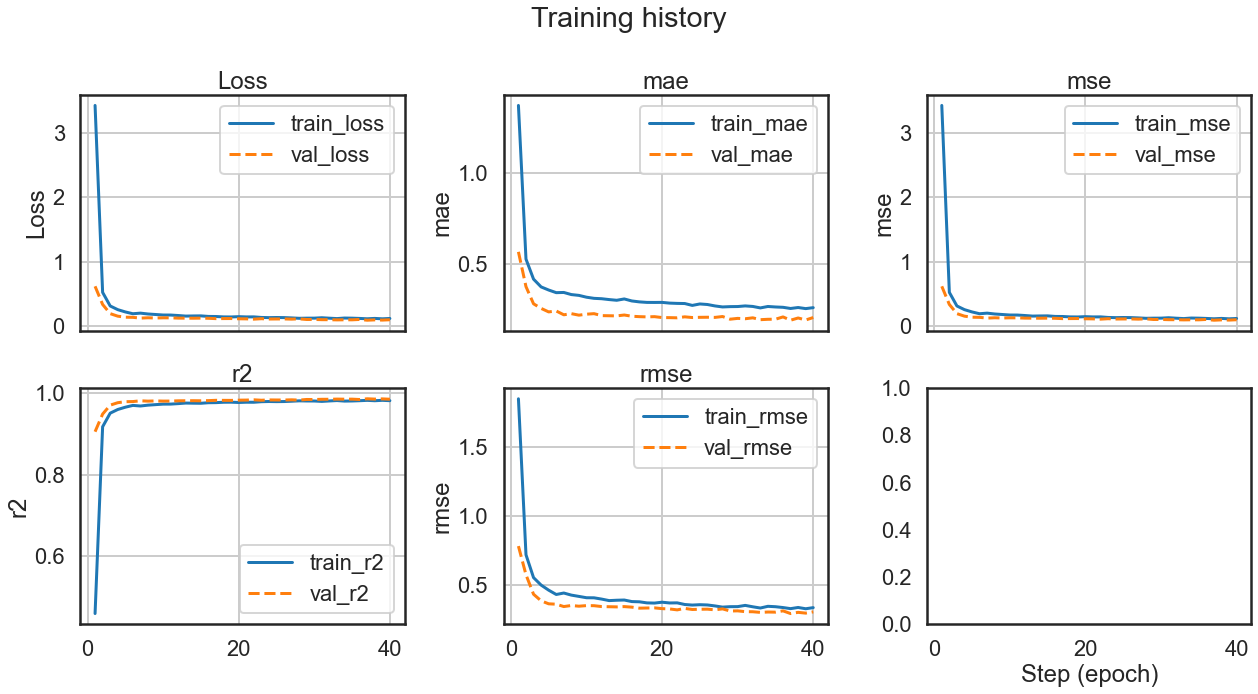

In [97]:
fig = plot_history(history, suptitle="Training history")
plt.tight_layout()
plt.show()

In [ ]:
# Final eval
val_loss, val_metrics = trainer.evaluate(val_loader)
print("Final val_loss:", val_loss)
print("Final val_metrics:", val_metrics)

Final val_loss: 0.08448734775185585
Final val_metrics: {'mse': 0.08448734879493713, 'mae': 0.19050389528274536, 'rmse': 0.2906670868396759, 'r2': 0.9870226979255676}
